In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Juliahi
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-12-06 14:40:23 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...


In [39]:
using LinearAlgebra, Dierckx, Random, Plots, Optim, Statistics, QuadGK

# Define a mutable Circle struct
mutable struct Circle
    x_coord::Float32
    y_coord::Float32
    radius::Float32
    label::Int
    radius_level::Int  # Add this field to keep track of radius levels
end

# Ray-casting algorithm to check if a point is inside a polygon
function point_in_polygon(px, py, x, y)
    n = length(x)
    inside = false
    j = n
    for i in 1:n
        if ((y[i] > py) != (y[j] > py)) &&
           (px < (x[j] - x[i]) * (py - y[i]) / (y[j] - y[i]) + x[i])
            inside = !inside
        end
        j = i
    end
    return inside
end

# Function to check if the circle is completely inside the contour
function circle_in_polygon(circle::Circle, polygon_x, polygon_y)
    num_samples = 100
    θ = range(0, stop=2π, length=num_samples)

    for angle in θ
        px = circle.x_coord + circle.radius * cos(angle)
        py = circle.y_coord + circle.radius * sin(angle)
        if !point_in_polygon(px, py, polygon_x, polygon_y)
            return false
        end
    end
    return true
end

# Function to create fine splines from given x, y data
function create_fine_spline(x, y; k=3, num_samples=240)
    t = collect(1:length(x))
    spl_x = Spline1D(t, x, k=k)
    spl_y = Spline1D(t, y, k=k)
    fine_t = range(1, length(x), length=num_samples)
    smooth_x = spl_x.(fine_t)
    smooth_y = spl_y.(fine_t)
    return smooth_x, smooth_y
end

# Function to determine the playground area based on min/max coordinates
function make_playground(x, y; margin_ratio=1)
    x_min, x_max = extrema(x)
    y_min, y_max = extrema(y)
    width = x_max - x_min
    height = y_max - y_min

    # Expand the area by a margin ratio
    x_min -= width * margin_ratio
    x_max += width * margin_ratio
    y_min -= height * margin_ratio
    y_max += height * margin_ratio

    return x_min, x_max, y_min, y_max
end

# Make circles within the defined playground with varied radii
function make_circles(num_circles; x_min=0.0, x_max=100.0, y_min=0.0, y_max=100.0)
    circles = Circle[]
    max_attempts = 1000  # Max attempts to find a non-overlapping position

    # Define radii and their respective counts
    radii_counts = [(9.0, round(Int, 1.0 * num_circles))]  # Start with all circles at radius r1

    id = 1  # Start ID counter
    for (radius, count) in radii_counts
        for _ in 1:count
            attempts = 0
            while attempts < max_attempts
                x = rand() * (x_max - x_min) + x_min  # Random x in [x_min, x_max]
                y = rand() * (y_max - y_min) + y_min  # Random y in [y_min, y_max]
                overlap = false

                # Check if this circle overlaps with any existing circles
                for circle in circles
                    if sqrt((circle.x_coord - x)^2 + (circle.y_coord - y)^2) < (circle.radius + radius)
                        overlap = true
                        break
                    end
                end

                if !overlap
                    # Store the circle with its properties, starting with radius_level = 1
                    push!(circles, Circle(x, y, radius, id, 1))
                    id += 1  # Increment ID for each circle
                    break
                end

                attempts += 1
            end

            # If no non-overlapping position found after max attempts, skip this circle
            if attempts == max_attempts
                println("Failed to place circle after $max_attempts attempts")
            end
        end
    end

    return circles  # Return an array of circles
end

# Function to compute the system energy
function compute_system_energy(circles, smooth_x, smooth_y)
    # Compute the energy between circles
    circle_energy = 0.0
    repulsion_penalty = 1e12

    for i in 1:length(circles)
        for j in 1:i-1
            circle1, circle2 = circles[i], circles[j]
            distance = sqrt((circle2.x_coord - circle1.x_coord)^2 + (circle2.y_coord - circle1.y_coord)^2) - (circle1.radius + circle2.radius)
            if distance > 0
                circle_energy += distance^2
            else
                circle_energy += repulsion_penalty * distance^2
            end
        end
    end

    # Compute contour energy: circles are pulled toward the center and repelled from contour boundary
    center_energy = 0.0

    contour_center_x = mean(smooth_x)
    contour_center_y = mean(smooth_y)

    for circle in circles
        distance_to_center = sqrt((circle.x_coord - contour_center_x)^2 + (circle.y_coord - contour_center_y)^2)
        if circle_in_polygon(circle, smooth_x, smooth_y)
            center_energy += distance_to_center  # Attraction force to the center
        else
            center_energy += 100 * distance_to_center^2
        end
    end

    # Total energy
    total_energy = circle_energy + 5 * center_energy
    return total_energy
end

# Function to visualize the contour and circles
function visualize_contour_and_circles(smooth_x, smooth_y, circles)
    plt = plot(aspect_ratio=:equal, smooth_x, smooth_y, label="Contour", linewidth=2, color=:blue)
    for circle in circles
        if circle_in_polygon(circle, smooth_x, smooth_y)
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :green, 0.3))
        else
            plot!(plt, [circle.x_coord + circle.radius * cos(θ) for θ in range(0, stop=2π, length=100)],
                       [circle.y_coord + circle.radius * sin(θ) for θ in range(0, stop=2π, length=100)],
                       label=false, fill=(0, :red, 0.3))
        end
    end
    scatter!(plt, [c.x_coord for c in circles], [c.y_coord for c in circles], label="Centers", color=:black, markersize=2)
    plot!(xlabel="X-axis", ylabel="Y-axis", title="Visualization of Contour and Circles")
    display(plt)
end

# Function to optimize the position of a single circle
function minimize_circle_energy(circle_index, circles, smooth_x, smooth_y)
    function objective(params)
        updated_circles = deepcopy(circles)
        updated_circles[circle_index] = Circle(params[1], params[2], circles[circle_index].radius, circles[circle_index].label, circles[circle_index].radius_level)
        return compute_system_energy(updated_circles, smooth_x, smooth_y)
    end

    initial_params = [circles[circle_index].x_coord, circles[circle_index].y_coord]
    result = optimize(objective, initial_params, SimulatedAnnealing())
    optimized_params = Optim.minimizer(result)
    circles[circle_index].x_coord = optimized_params[1]
    circles[circle_index].y_coord = optimized_params[2]
end

# Function to optimize all circles once
function optimize_all_circles_once(circles, smooth_x, smooth_y)
    for i in 1:length(circles)
        minimize_circle_energy(i, circles, smooth_x, smooth_y)
    end
    return circles
end

# Example usage
x = [79, 78, 77, 77, 76, 77, 77, 76, 74, 73, 72, 71, 68, 67, 56, 55, 51, 50, 48, 47, 46, 44, 42, 39, 37, 36, 33, 32, 30, 28, 28, 28, 27, 27, 26, 23, 23, 24, 24, 25, 25, 26, 26, 25, 25, 24, 24, 23, 23, 22, 22, 23, 23, 24, 28, 28, 29, 32, 34, 35, 36, 39, 40, 46, 47, 51, 52, 53, 54, 55, 56, 57, 58, 66, 67, 70, 70, 71, 72, 73, 74, 75, 76, 76, 78, 79, 79, 81, 81, 83, 83, 84, 84, 85, 85, 87, 87, 88, 90, 90, 91, 88, 87, 87, 88, 90, 91, 91, 90, 89, 87, 85, 85, 87, 89, 90, 90, 89, 88, 87, 87, 85, 85, 85, 84, 82, 80, 80, 79, 78, 78, 79, 81, 82, 82, 83, 83, 84, 81, 81, 80, 79]
y = [66, 67, 67, 71, 72, 73, 76, 77, 77, 76, 76, 75, 75, 74, 74, 75, 75, 76, 76, 77, 77, 79, 79, 82, 82, 83, 83, 82, 82, 80, 78, 81, 82, 84, 85, 85, 86, 87, 89, 90, 92, 93, 95, 96, 101, 102, 108, 109, 112, 113, 123, 124, 126, 126, 130, 131, 132, 132, 134, 134, 135, 135, 136, 136, 137, 137, 138, 138, 139, 139, 140, 140, 139, 139, 138, 138, 137, 136, 136, 135, 135, 134, 134, 133, 131, 131, 130, 128, 127, 125, 123, 122, 119, 118, 117, 115, 114, 113, 113, 112, 111, 111, 110, 107, 106, 106, 107, 107, 95, 94, 95, 95, 93, 90, 88, 88, 89, 83, 82, 82, 81, 79, 77, 76, 78, 79, 79, 74, 74, 73, 70, 69, 69, 70, 73, 73, 72, 71, 68, 67, 67, 66]

smooth_x, smooth_y = create_fine_spline(x, y)
x_min, x_max, y_min, y_max = make_playground(x, y)
num_circles = 60
num_iterations = 8 * num_circles
circles = make_circles(num_circles, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max)
optimized_circles = deepcopy(circles)  # Make a copy to optimize

# Define the radii levels
radii_levels = [9.0, 7.0, 4.0, 2.0]  # Corresponding to r1, r2, r3, r4

# Assign initial radius level index to each circle
for circle in optimized_circles
    circle.radius_level = 1  # Start with the first radius level (r1)
end

#output_dir = "C:/Users/mouli/OneDrive/Documents/Math512/IMG"

# Iterative removal and optimization with radius reduction
max_iterations = 1
for iteration in 1:max_iterations
    println("Iteration $iteration")
    #visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)
    #savefig("output_dir/image_00_iteration.png")

    # Run the optimization on all circles
    optimized_circles = optimize_all_circles_once(optimized_circles, smooth_x, smooth_y)
    #visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)
    #savefig("output_dir/image_01_
iteration.png")
    # Check each circle
    for circle in optimized_circles
        # While the circle is not completely inside the contour and radius level is less than maximum
        while !circle_in_polygon(circle, smooth_x, smooth_y) && circle.radius_level < length(radii_levels)
            # Increase the radius level index to reduce the radius
            circle.radius_level += 1
            # Update the circle's radius to the next smaller radius
            circle.radius = radii_levels[circle.radius_level]
            println("Circle
(circle.radius)")

            #visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)
            #savefig("output_dir/image_
circle $iteration.png")
            # Re-optimize the circle's position
            minimize_circle_energy(findfirst(c -> c.label == circle.label, optimized_circles), optimized_circles, smooth_x, smooth_y)
        end
    end



end
optimized_circles = [circle for circle in optimized_circles if circle_in_polygon(circle, smooth_x, smooth_y)]
# Visualize the final result
visualize_contour_and_circles(smooth_x, smooth_y, optimized_circles)
#savefig("$output_dir/image_999.png")

LoadError: invalid redefinition of constant Circle

First 5 interpolated points:
θ = 0.0: (79.00000000000003, 66.00000000000001)
θ = 0.03157379551346526: (77.85337833266028, 67.04526311804254)
θ = 0.06314759102693052: (76.71689528744002, 67.24426538949498)
θ = 0.09472138654039577: (77.05842361453803, 68.87333010469307)
θ = 0.12629518205386103: (77.1072442420286, 70.81660659028057)
θ = 0.1578689775673263: (76.00316459028863, 71.97463797838185)
θ = 0.18944277308079155: (77.0795411888712, 73.08771872855542)
θ = 0.2210165685942568: (77.49280984850293, 74.65133613242085)
θ = 0.25259036410772207: (76.87904938741933, 76.18848941695607)
θ = 0.2841641596211873: (75.6485094864103, 77.15441816312341)
θ = 0.3157379551346526: (74.06738600592911, 77.05173437979343)
θ = 0.3473117506481178: (72.94536759375113, 75.98866771408595)
θ = 0.3788855461615831: (71.53380297796981, 75.6332692982146)
θ = 0.41045934167504833: (70.3181337254708, 74.80384165392788)
θ = 0.4420331371885136: (68.64661831678934, 75.07094590042509)
θ = 0.47360693270197884: (67.3616594691

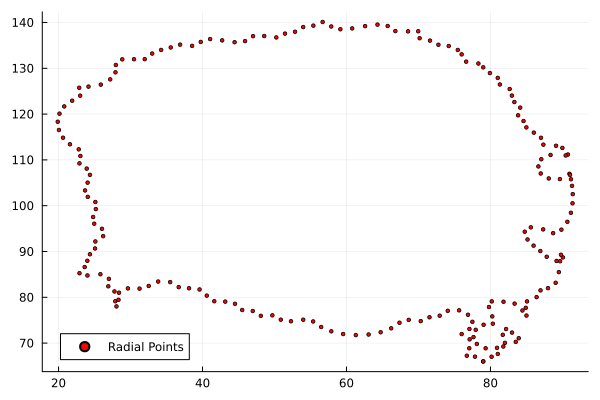

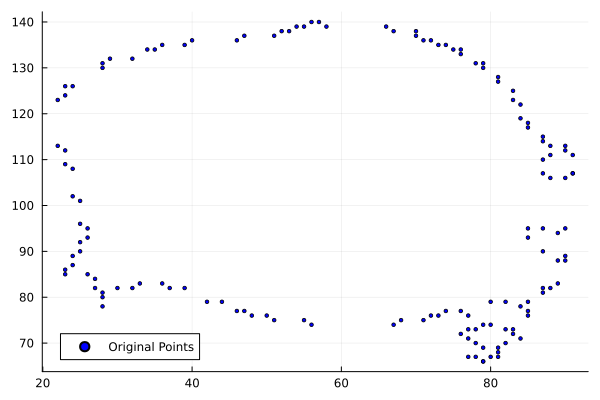

In [ ]:
# Calculate centroid
centroid_x = mean(x)
centroid_y = mean(y)

# Calculate angles and distances for each point relative to centroid
θ = atan.(y .- centroid_y, x .- centroid_x)
r = sqrt.((x .- centroid_x).^2 + (y .- centroid_y).^2)


arclength = [0.0]
for i in 2:length(x)
    push!(arclength, arclength[end] + sqrt((x[i] - x[i-1])^2 + (y[i] - y[i-1])^2))
end

# Normalize arclength to [0, 2π]
total_arclength = arclength[end]
t = (arclength ./ total_arclength) .* 2π
t = t .+ range(0, stop=1e-6, length=length(t))  # Add small perturbation

# Create the splines using arclength as parameter
spline_x = Spline1D(t, x; k=3, periodic=true)  # Using arclength for parameterization
spline_y = Spline1D(t, y; k=3, periodic=true)  # Using arclength for parameterization

# Generate points along the curve using finer arclength values
t_fine = range(0, 2π, length=200)
#x_interp = spline_x(t_fine)
#y_interp = spline_y(t_fine)

x_interp = [spline_x(t) for t in t_fine]
y_interp = [spline_y(t) for t in t_fine]


# Print first few interpolated points
println("First 5 interpolated points:")
for i in 1:200
    println("θ = $(t_fine[i]): ($(x_interp[i]), $(y_interp[i]))")
end

# Show the plot
display(scatter(x_interp, y_interp, label="Radial Points", color="red", markersize=2))
display(scatter(x, y, label="Original Points", color="blue", markersize=2))


In [ ]:
Pkg.add("QuadGK")
using QuadGK

# Define the integrand function for Green's theorem
# f(t) = x(t)dy/dt - y(t)dx/dt
function integrand(t)
    x = spline_x(t)
    y = spline_y(t)
    dxdt = derivative(spline_x, t)
    dydt = derivative(spline_y, t)
    return x * dydt - y * dxdt
end

# Calculate area using QuadGK
# Area = 1/2 ∮ (x dy - y dx) = 1/2 ∫ (x dy/dt - y dx/dt) dt
area, error = quadgk(integrand, 0, 2π)  # Assuming parameterization is over [0, 2π]

# Take absolute value since orientation might give negative area
area = abs(area) * 0.5
println("Area enclosed by the curve: ", area)
println("Estimated error: ", error)

# Print a few values of the integrand for verification
println("\nIntegrand values at sample points:")
for t in [0, π/2, π, 3π/2]
    println("t = $t: $(integrand(t))")
end

   Resolving package versions...
   Installed QuadGK ─ v2.11.1
    Updating `~/.julia/environments/v1.8/Project.toml`
  [1fd47b50] + QuadGK v2.11.1
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [1fd47b50] + QuadGK v2.11.1
Precompiling project...
  ✓ QuadGK
  1 dependency successfully precompiled in 2 seconds. 188 already precompiled.


Area enclosed by the curve: 3663.1789241576857
Estimated error: 0.0001078096391138512

Integrand values at sample points:
t = 0.0: 1673.574092613783
t = 1.5707963267948966: 4653.599576215723
t = 3.141592653589793: -6918.977696665589
t = 4.71238898038469: -2710.270440277268


In [ ]:
import Pkg; Pkg.add("Roots")

   Resolving package versions...
   Installed CommonSolve ────── v0.2.4
   Installed Accessors ──────── v0.1.39
   Installed Roots ──────────── v2.2.2
   Installed CompositionsBase ─ v0.1.2
    Updating `~/.julia/environments/v1.8/Project.toml`
  [f2b01f46] + Roots v2.2.2
    Updating `~/.julia/environments/v1.8/Manifest.toml`
  [7d9f7c33] + Accessors v0.1.39
  [38540f10] + CommonSolve v0.2.4
  [a33af91c] + CompositionsBase v0.1.2
  [f2b01f46] + Roots v2.2.2
Precompiling project...
  ✓ CommonSolve
  ✓ CompositionsBase
  ✓ Accessors
  ✓ Roots
  4 dependencies successfully precompiled in 7 seconds. 189 already precompiled.


In [ ]:
function compute_circle_area_monte_carlo(circle, spline_x, spline_y, num_samples)
    cx, cy, r = circle.x_coord, circle.y_coord, circle.radius

    points_inside = 0
    total_points = 0

    for _ in 1:num_samples
        # Generate random point within the bounding square of the circle
        x = cx + r * (2 * rand() - 1)
        y = cy + r * (2 * rand() - 1)

        # Check if point is inside circle first
        if (x - cx)^2 + (y - cy)^2 <= r^2
            total_points += 1

            # Then check if point is inside contour
            if point_in_polygon(x, y, spline_x, spline_y)
                points_inside += 1
            end
        end
    end

    return (points_inside / total_points) * (π * r^2)
end

unoptimized_total_area = 0.0
optimized_total_area = 0.0

for circle in original_circles_copy
    unoptimized_total_area += compute_circle_area_monte_carlo(circle, spline_x, spline_y, 20000)
end

for circle in optimized_circles
    optimized_total_area += compute_circle_area_monte_carlo(circle, spline_x, spline_y, 20000)
end

unoptimized_packing_density = unoptimized_total_area / area
optimized_packing_density = optimized_total_area / area

println("Unoptimized Packing Density: ", unoptimized_packing_density)
println("Optimized Packing Density: ", optimized_packing_density)

Unoptimized Packing Density: 0.49160979946750816
Optimized Packing Density: 0.7536945986470024
